In [1]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
import cv2
import os


In [2]:
# To try: data augmentation to increase the size of my data set and kaggle dataset. 
# Try to make a new dataset on white background only and train the model to see if it can learn the pattern.
# Idea: learn the pattern on white background so it is easy and we are sure it learns the pattern.

# Motivation!!!!! It is hard and it takes time and it will eventually work!!
#It works on white background!

In [3]:
gpu_details = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_details:
    print(gpu)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [21]:
dataset = keras.utils.image_dataset_from_directory(
    'kaggle_dataset_cropped',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(150, 150),
    shuffle=True
   
)

Found 7386 files belonging to 4 classes.


In [16]:
fine_tune_ds = keras.utils.image_dataset_from_directory(
    'my_images',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(150, 150),
    shuffle=True
)

Found 141 files belonging to 4 classes.


In [35]:
# RUN IF .IPYNB CHECKPOINTS AND CORRUPT DATA SET
import shutil

data_dir = "my_images"

for root, dirs, files in os.walk(data_dir):
    for dir_name in dirs:
        if dir_name == ".ipynb_checkpoints":
            checkpoint_path = os.path.join(root, dir_name)
            shutil.rmtree(checkpoint_path)  # Delete the folder
            print(f"Deleted: {checkpoint_path}")


In [36]:
from collections import Counter

all_labels = []
for elements, labels in dataset:
    # print(labels)
    all_labels.extend(labels.numpy())
label_counts = Counter(all_labels)

class_names = dataset.class_names 
# Map class indices to their names
for class_idx, count in label_counts.items():
    print(f"{class_names[class_idx]}: {count}")


north: 1852
left: 1816
right: 1855
south: 1863


In [37]:
from collections import Counter

all_labels = []
for elements, labels in fine_tune_ds:
    # print(labels)
    all_labels.extend(labels.numpy())
label_counts = Counter(all_labels)

class_names = fine_tune_ds.class_names 
# Map class indices to their names
for class_idx, count in label_counts.items():
    print(f"{class_names[class_idx]}: {count}")


south: 41
north: 30
right: 36
left: 33


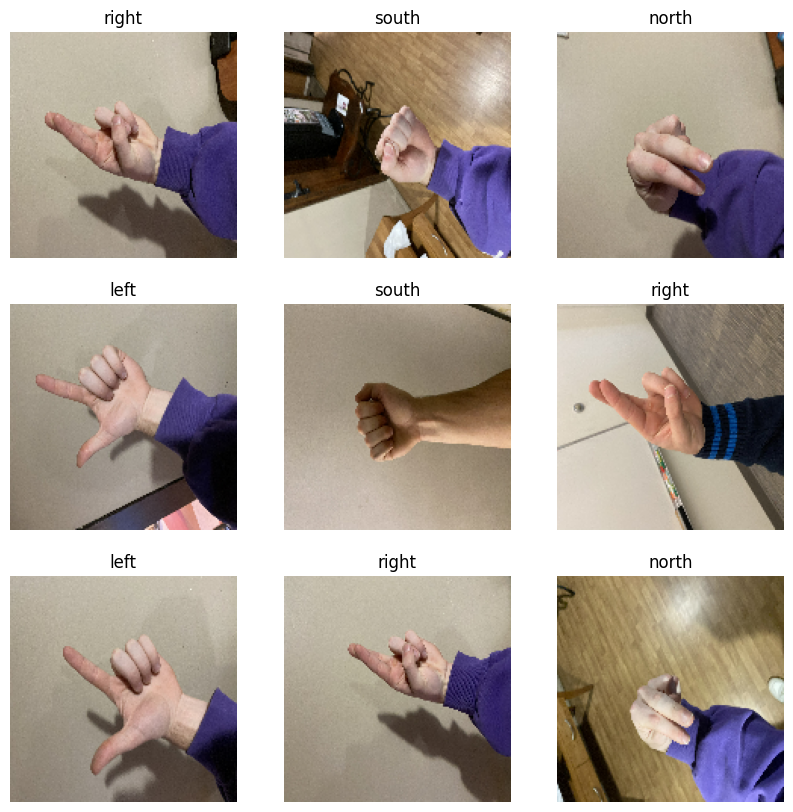

In [19]:

# Get a batch of images and labels
class_names = fine_tune_ds.class_names  # Get class names
for images, labels in fine_tune_ds.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i]])  # Show class label
        plt.axis("off")
    plt.show()


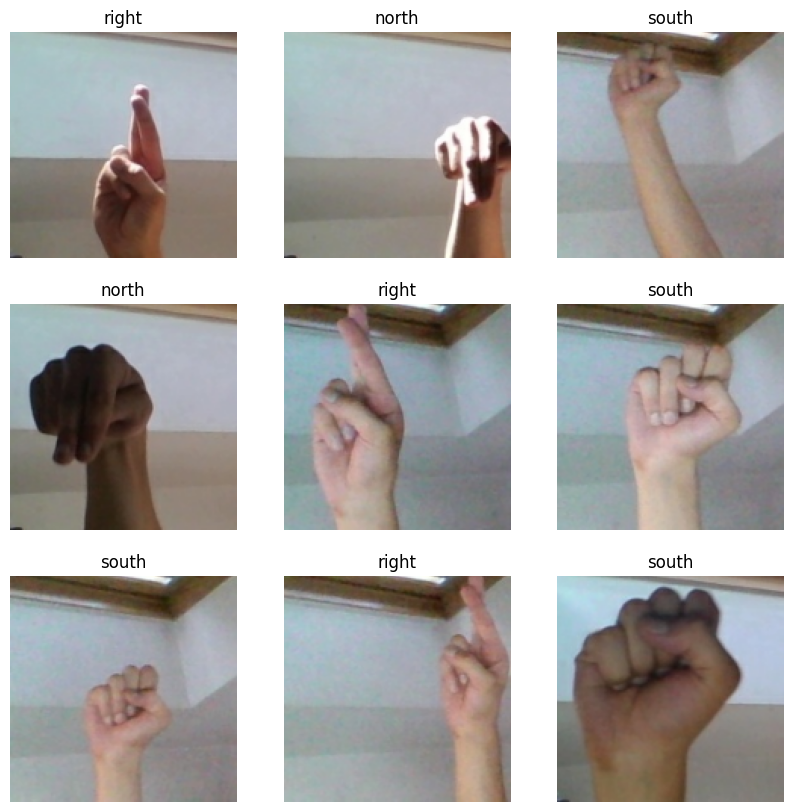

In [22]:

# Get a batch of images and labels
class_names = dataset.class_names  # Get class names
for images, labels in dataset.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i]])  # Show class label
        plt.axis("off")
    plt.show()


In [23]:
dataset=dataset.unbatch()
training_ds, validation_ds = tf.keras.utils.split_dataset(
    dataset, left_size=0.8, shuffle=False, seed=None
)
print(f"length training data set: {len(training_ds)}")
print(f"length validation data set: {len(validation_ds)}")
training_ds = training_ds.batch(16)
validation_ds = validation_ds.batch(16)
print(f"# of batch for training data set: {len(training_ds)}")
print(f"# of batch for validation data set: {len(validation_ds)}")

length training data set: 5909
length validation data set: 1477
# of batch for training data set: 370
# of batch for validation data set: 93


length training data set: 113
length validation data set: 28


Original dataset size: 9
Augmented dataset size: 27
Final dataset size: 36


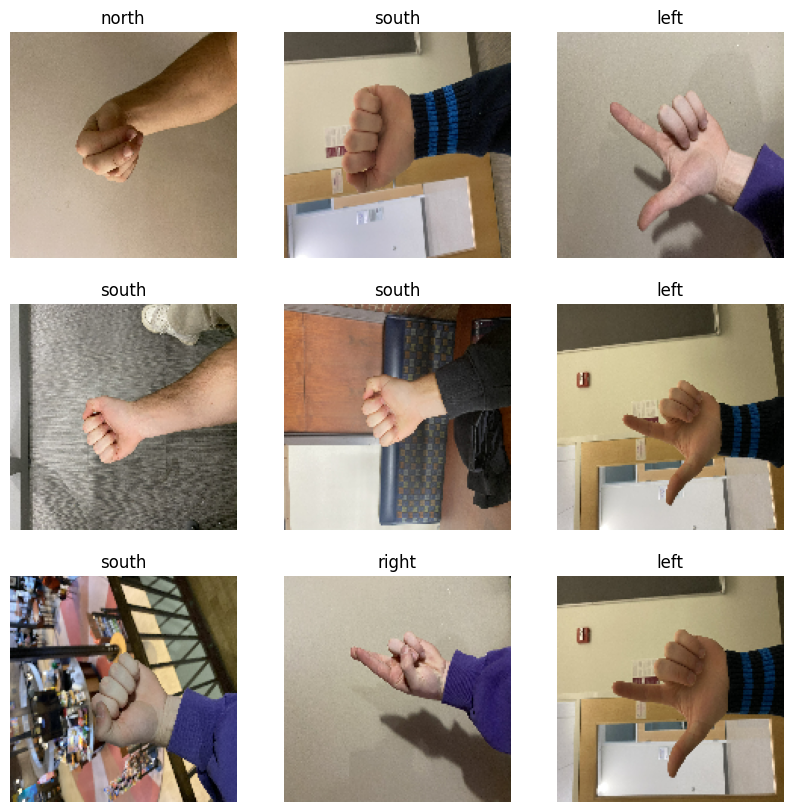

In [24]:


# Define augmentation layers
augmentation_layers = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

# Function to apply augmentation multiple times per image
def augment_multiple_times(image, label, num_augmentations=3):
    """Applies augmentation multiple times to each image."""
    augmented_images = [augmentation_layers(image) for _ in range(num_augmentations)]
    augmented_labels = [label] * num_augmentations  # Repeat labels
    return tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Apply augmentation multiple times and flatten the dataset
augmented_datasets = fine_tune_ds.flat_map(lambda x, y: augment_multiple_times(x, y, num_augmentations=3))

# Combine original dataset with augmented dataset
expanded_training_ds = fine_tune_ds.concatenate(augmented_datasets)

# Check dataset size
print("Original dataset size:", len(list(fine_tune_ds)))
print("Augmented dataset size:", len(list(augmented_datasets)))
print("Final dataset size:", len(list(expanded_training_ds)))

# Verify augmentation by displaying images
for images, labels in expanded_training_ds.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i]])  # Show class label
        plt.axis("off")
    plt.show()


In [25]:
expanded_training_ds=expanded_training_ds.unbatch()
exft_training_ds, exft_validation_ds = tf.keras.utils.split_dataset(
    expanded_training_ds, left_size=0.8, shuffle=False, seed=None
)
print(f"length training data set: {len(exft_training_ds)}")
print(f"length validation data set: {len(exft_validation_ds)}")
exft_training_ds = exft_training_ds.batch(16)
exft_validation_ds = exft_validation_ds.batch(16)


length training data set: 451
length validation data set: 113


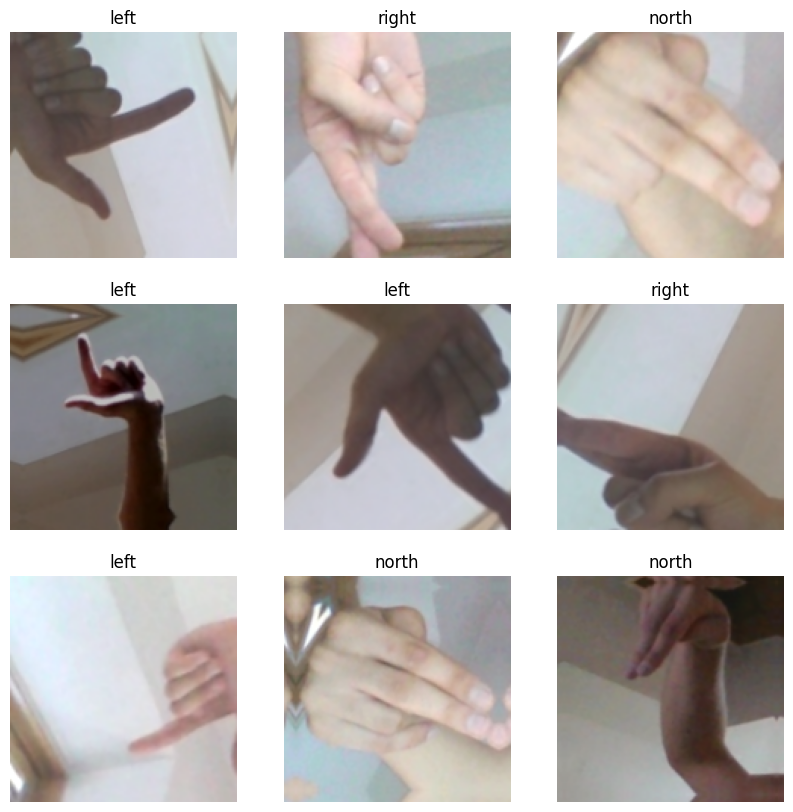

In [26]:
#Augmentation (flips, zoom...)

augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),                           
    layers.RandomContrast(0.2),              
    layers.RandomBrightness(0.2),             
]

def augmentation_layer(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

training_ds = training_ds.map(lambda x, y: (augmentation_layer(x), y))

for images, labels in training_ds.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i]])  # Show class label
        plt.axis("off")
    plt.show()


In [23]:
len(training_ds)

370

In [27]:
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)

base_model = keras.applications.Xception(
    weights=None, 
    input_shape=(150, 150, 3),
    classifier_activation="softmax",
    include_top=False
)
base_model.trainable = True

inputs = keras.Input(shape=(150, 150, 3))

# x = data_augmentation(inputs)
x = scale_layer(inputs)

# Keep Xception model trainable

# Pass through Xception
x = base_model(x)

# Global Average Pooling to flatten features
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

# Fully connected layer (256 neurons, non-trainable)
dense_layer = layers.Dense(256, activation="relu")
dense_layer.trainable = True  # Freeze this layer
x = dense_layer(x)
x = layers.Dropout(0.3)(x)

# Fully connected layer (256 neurons, non-trainable)
dense_layer = layers.Dense(256, activation="relu")
dense_layer.trainable = True  # Freeze this layer
x = dense_layer(x)

x = layers.Dropout(0.3)(x)  # Prevent overfitting

# Final classification layer (4 classes, non-trainable)
output_layer = layers.Dense(4, activation="softmax")
output_layer.trainable = True 
output = output_layer(x)

# Create the model
model = keras.Model(inputs, output)

# Show trainable layers summary
model.summary(show_trainable=True)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_6 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 256)           │    524,544 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 256)           │     65,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 4)             │      1,028 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,452,844 (81.84 MB)

 Trainable params: 21,398,316 (81.63 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early Stopping: Stops training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",   
    patience=5,           
    restore_best_weights=True  
)

# Learning Rate Scheduler: Reduces LR when validation loss stops improving
lr_schedule = ReduceLROnPlateau(
    monitor="val_loss",   
    factor=0.5,          
    patience=3,           
    verbose=1,          
    min_lr=1e-7           
)


In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
print("Fit model on training data")
history = model.fit(
    training_ds,
    epochs=10,
    callbacks=[early_stopping, lr_schedule]
)

Fit model on training data
Epoch 1/10


I0000 00:00:1742421291.841326  161972 service.cc:146] XLA service 0x7fbfbc001ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742421291.841369  161972 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
E0000 00:00:1742421297.898106  161972 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1742421298.013750  161972 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1742421298.614922  161972 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1742421298.727076  161972 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal 

  3/370 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - loss: 1.6505 - sparse_categorical_accuracy: 0.2986   

I0000 00:00:1742421306.563103  161972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


369/370 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.3540 - sparse_categorical_accuracy: 0.4145

E0000 00:00:1742421346.394658  161975 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1742421346.505954  161975 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


370/370 ━━━━━━━━━━━━━━━━━━━━ 72s 134ms/step - loss: 1.3526 - sparse_categorical_accuracy: 0.4152 - learning_rate: 0.0010
Epoch 2/10


/mounts/faraday/software/anaconda/envs/py312/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,sparse_categorical_accuracy
  current = self.get_monitor_value(logs)
/mounts/faraday/software/anaconda/envs/py312/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,sparse_categorical_accuracy,learning_rate.
  callback.on_epoch_end(epoch, logs)


370/370 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7689 - learning_rate: 0.0010
Epoch 3/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - loss: 0.4511 - sparse_categorical_accuracy: 0.8412 - learning_rate: 0.0010
Epoch 4/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - loss: 0.3918 - sparse_categorical_accuracy: 0.8729 - learning_rate: 0.0010
Epoch 5/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - loss: 0.3544 - sparse_categorical_accuracy: 0.8830 - learning_rate: 0.0010
Epoch 6/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - loss: 0.3225 - sparse_categorical_accuracy: 0.8958 - learning_rate: 0.0010
Epoch 7/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - loss: 0.3248 - sparse_categorical_accuracy: 0.9007 - learning_rate: 0.0010
Epoch 8/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - loss: 0.2559 - sparse_categorical_accuracy: 0.9135 - learning_rate: 0.0010
Epoch 9/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - loss: 0.2608 - sparse_categorical_accu

In [52]:
print(history.history)

{'loss': [1.5538971424102783, 1.3453704118728638, 1.3566316366195679, 1.2746846675872803, 1.3020356893539429, 1.289331078529358, 1.2537935972213745, 1.23114812374115, 1.2470370531082153, 1.1585588455200195], 'sparse_categorical_accuracy': [0.3370535671710968, 0.390625, 0.3727678656578064, 0.4084821343421936, 0.4241071343421936, 0.4330357015132904, 0.4107142984867096, 0.46875, 0.4375, 0.4933035671710968]}


In [68]:
#Try to predict an image of my data set with model trained with kaggle dataset
img_path = "my_images/south/IMG_2396.jpg"
img_size = (150, 150)  
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)

img_array = (img_array / 127.5) - 1.0  

# Expand dimensions to match model's expected input shape (batch size of 1)
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[9.9999964e-01 1.4263572e-10 9.5546135e-08 2.1635934e-07]]


In [69]:
loss, accuracy = model.evaluate(exft_validation_ds)
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Loss: {loss}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - loss: 20.7317 - sparse_categorical_accuracy: 0.3943
Validation Accuracy: 0.4555555582046509
Validation Loss: 16.604116439819336


In [70]:
loss, accuracy = model.evaluate(exft_training_ds)
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Loss: {loss}')


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 11.7984 - sparse_categorical_accuracy: 0.6397
Validation Accuracy: 0.5642458200454712
Validation Loss: 16.193567276000977


In [71]:
loss, accuracy = model.evaluate(validation_ds)
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Loss: {loss}')


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 11.9193 - sparse_categorical_accuracy: 0.1316
Validation Accuracy: 0.13337847590446472
Validation Loss: 11.41215705871582


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


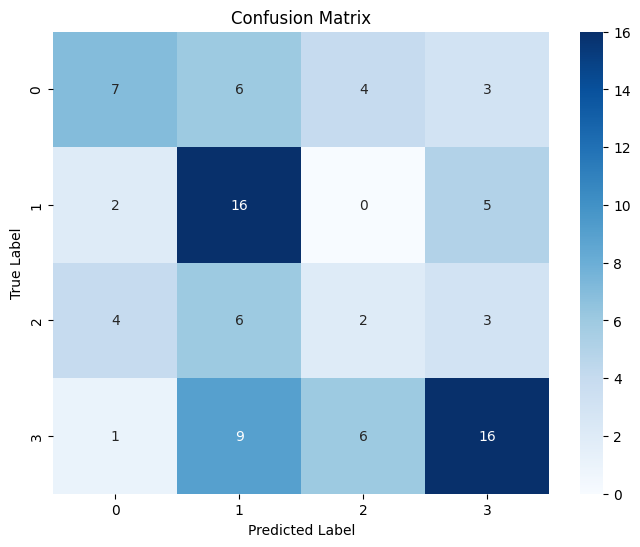

In [72]:
y_true = []
y_pred = []

for images, labels in exft_validation_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # Convert one-hot to class index
    y_true.extend(labels)  # Get true labels

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

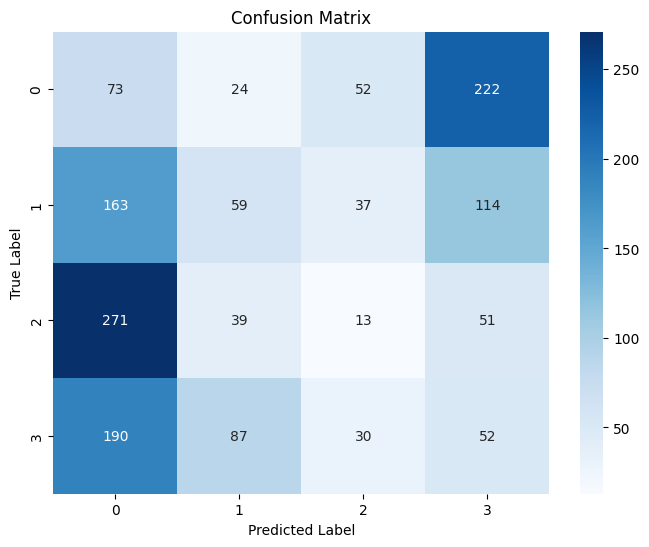

In [74]:
#my images
y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # Convert one-hot to class index
    y_true.extend(labels)  # Get true labels

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [42]:
loss, accuracy = model.evaluate(fine_tune_ds)
print(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - loss: 4.4498 - sparse_categorical_accuracy: 0.2541
4.888895034790039 0.19736842811107635


In [26]:
model.save('model_v0test.keras')

In [102]:
# Load the image
img_path = "test_image.jpg"  # Update with your image path
img_size = (150, 150)  # Change this to match your model's input shape

# Load image and resize
img = image.load_img(img_path, target_size=img_size)

# Convert image to array
img_array = image.img_to_array(img)

img_array = (img_array / 127.5) - 1.0  

# Expand dimensions to match model's expected input shape (batch size of 1)
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
print(prediction)
k=None
for count, i in enumerate(prediction[0]):
    if i>0.9:
        k = count
print(k)
        


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[1.29627775e-08 3.15901634e-05 2.66294256e-02 9.73338962e-01]]
3


In [31]:
dense_layer = model.layers[-5]
dense_layer.trainable=True
dense_layer = model.layers[-3]
dense_layer.trainable=True
ouput_layer = model.layers[-1]
output_layer.trainable=True
xception = model.layers[-8]
xception.trainable = False


model.summary(show_trainable=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_6 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 256)           │    524,544 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 256)           │     65,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 4)             │      1,028 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 42,851,162 (163.46 MB)

 Trainable params: 591,364 (2.26 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 21,398,318 (81.63 MB)

In [32]:
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [34]:
epochs = 20
print("Fitting the end-to-end model")
history = model.fit(exft_training_ds, epochs=epochs, callbacks=[early_stopping, lr_schedule])

Fitting the end-to-end model
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2974 - sparse_categorical_accuracy: 0.3692 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2777 - sparse_categorical_accuracy: 0.4034 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2765 - sparse_categorical_accuracy: 0.3584 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2658 - sparse_categorical_accuracy: 0.4160 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2429 - sparse_categorical_accuracy: 0.3866 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.3906 - learning_rate: 0.0010
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2211 - sparse_categorical_accuracy: 0.3508 - learning_rate: 0.0010
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2290 - sparse_categ

In [145]:
print(history.history)

{'loss': [1.1838654279708862, 1.192270040512085, 1.1470061540603638, 1.2187825441360474, 1.1340856552124023, 1.1331470012664795, 1.1343953609466553, 1.2317911386489868, 1.1584259271621704, 1.2225767374038696, 1.157754898071289, 1.157417893409729, 1.2054497003555298, 1.1809741258621216, 1.188947081565857, 1.154783010482788, 1.1755268573760986, 1.1431061029434204, 1.1218066215515137, 1.118237853050232], 'sparse_categorical_accuracy': [0.4285714328289032, 0.4196428656578064, 0.4285714328289032, 0.4017857015132904, 0.4821428656578064, 0.5, 0.4642857015132904, 0.4196428656578064, 0.4821428656578064, 0.4107142984867096, 0.4375, 0.4107142984867096, 0.4732142984867096, 0.4285714328289032, 0.4285714328289032, 0.4553571343421936, 0.4464285671710968, 0.4285714328289032, 0.4375, 0.4642857015132904], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513,

In [36]:
loss, accuracy = model.evaluate(exft_validation_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - loss: 1.0279 - sparse_categorical_accuracy: 0.4858


In [35]:
loss, accuracy = model.evaluate(validation_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.4785 - sparse_categorical_accuracy: 0.1832


In [79]:
loss, accuracy = model.evaluate(exft_validation_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - loss: 1.9623 - sparse_categorical_accuracy: 0.2435


In [40]:
img_path = "south_test.jpg"
img_size = (150, 150)  
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)

img_array = (img_array / 127.5) - 1.0  

# Expand dimensions to match model's expected input shape (batch size of 1)
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[1.9176160e-04 1.9960332e-04 8.7446161e-04 9.9873418e-01]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


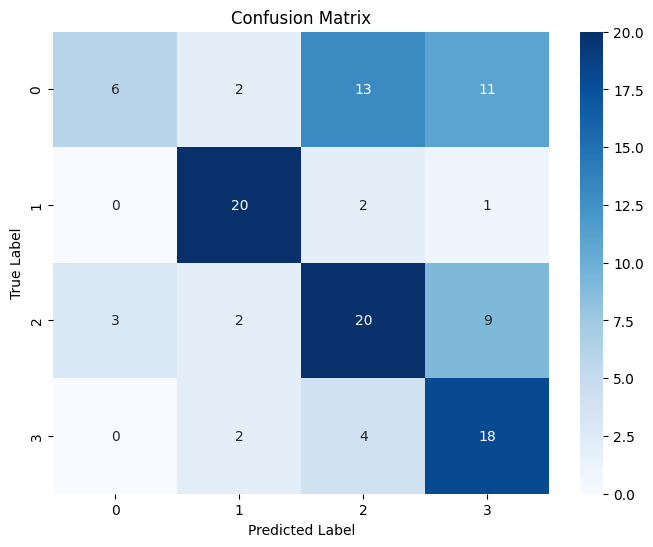

In [39]:
#my images
y_true = []
y_pred = []

for images, labels in exft_validation_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # Convert one-hot to class index
    y_true.extend(labels)  # Get true labels

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
